# Description of dataset in NetCDF4 format

In [2]:
import xarray as xr

ds = xr.open_dataset("era5_data.nc", engine='netcdf4')

print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 7, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 960B 2024-07-01 ... 2024-07-0...
  * pressure_level  (pressure_level) float64 56B 1e+03 850.0 ... 200.0 100.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 2kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

## Plot an example of wind vector field

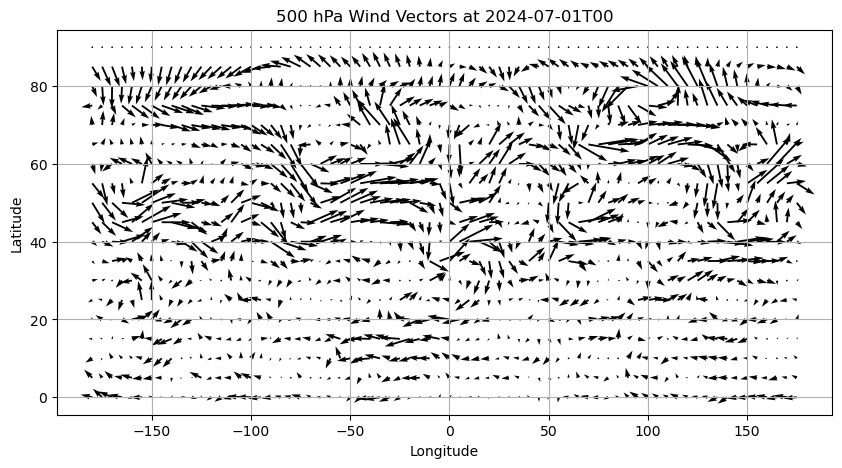

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. Open your NetCDF4 ERA5 file
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")

# 2. Pick a pressure level (hPa) and time index
plev = 500.0    # hPa
tidx = 0        # first time step

# 3. Extract the u/v wind and lon/lat coordinates
u = ds.u.sel(pressure_level=plev).isel(valid_time=tidx)
v = ds.v.sel(pressure_level=plev).isel(valid_time=tidx)
lons = ds.longitude
lats = ds.latitude

# 4. Downsample for readability
step = 20
u2   = u.values[::step, ::step]
v2   = v.values[::step, ::step]
lon2 = lons.values[::step]
lat2 = lats.values[::step]

# 5. Build a title string with the datetime
time_str = np.datetime_as_string(ds.valid_time.values[tidx], unit="h")

# 6. Plot
plt.figure(figsize=(10,5))
plt.quiver(lon2, lat2, u2, v2, scale=700)        # adjust scale to taste
plt.title(f"{int(plev)} hPa Wind Vectors at {time_str}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


# Draw a noisy windfield with interpolation

- Problem: it takes too long to get a wind vector at a given point (around 30 sec in my computer)

In [ ]:
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
from env.ERA_wind_field import WindField  # your modified class

# 1. load your ERA5 file
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")

# 2. pick a reference start_time (should match your dataset’s first valid_time)
start_time = datetime(2024, 7, 1, 0, 0)

# 3. wrap it, giving an explicit seed for reproducibility
wf = WindField(ds, start_time, noise_seed=12345)

# 4. specify the query time and compute elapsed_time
query_time = datetime(2024, 7, 1, 12, 30)
elapsed = query_time - start_time  # a datetime.timedelta

# 5. query at (lon, lat, pressure, elapsed_time)
for i in range(2):
    wf.reset_noise(noise_seed=i)   # picks a fresh random seed internally
    pt = wf.get_wind(
        lon          = -75.04,
        lat          =  40.33,
        pressure     =  400.0,
        elapsed_time = elapsed  # your timedelta
    )
    print(f"draw {i}: u={pt.u:.2f}, v={pt.v:.2f}")

draw 0: u=30.85, v=9.46
draw 1: u=30.32, v=8.96
